In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans


In [3]:
df = pd.read_csv(r"C:\Users\Rakshitha\Downloads\online_retail.csv")

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df.duplicated().sum()

5268

In [7]:
df.shape


(541909, 8)

# PREPROCESSING

In [8]:
df = df.dropna(subset=['CustomerID'])  # Drop rows where CustomerID is missing

# Step 2: Exclude cancelled invoices (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Step 3: Remove rows with non-positive Quantity or UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# (Optional) Step 4: Remove duplicate rows
df = df.drop_duplicates()


# EDA 

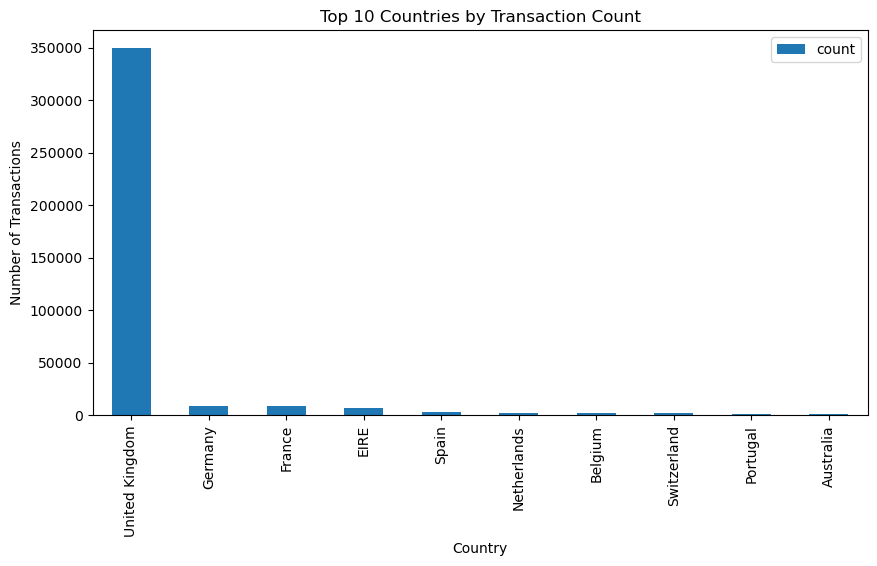

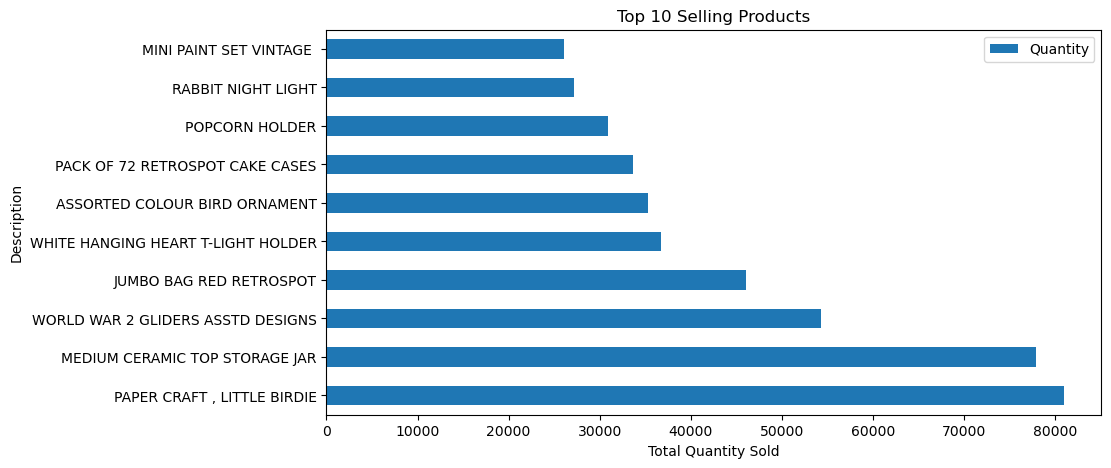

C:\Users\Rakshitha\AppData\Local\Temp\ipykernel_56180\1447765240.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('InvoiceDate').resample('M')['Quantity'].sum().plot(figsize=(12, 5), title='Monthly Sales Trend')


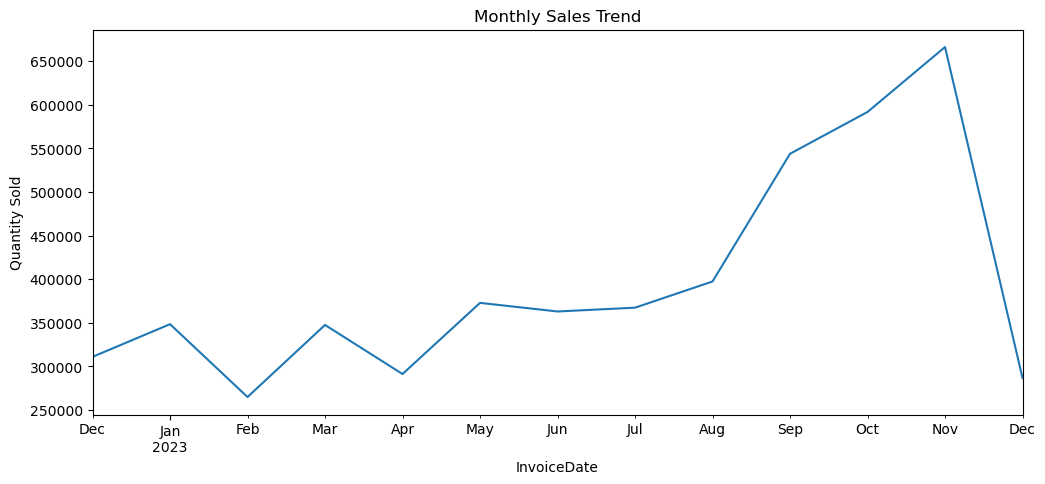

Text(0, 0.5, 'Frequency')

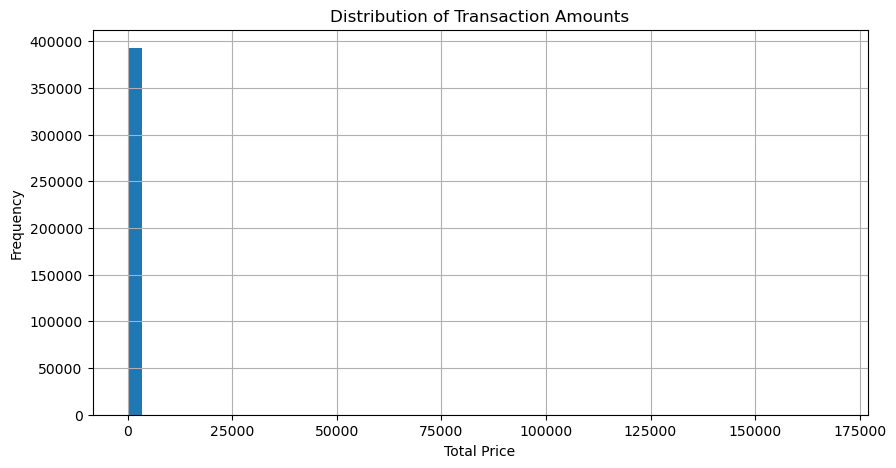

In [9]:
top_countries = df['Country'].value_counts().head(10)
top_countries.plot(kind='bar', figsize=(10, 5), title='Top 10 Countries by Transaction Count')
plt.ylabel('Number of Transactions')
plt.legend()
plt.show()

top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', figsize=(10, 5), title='Top 10 Selling Products')
plt.xlabel('Total Quantity Sold')
plt.legend()
plt.show()


df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.set_index('InvoiceDate').resample('M')['Quantity'].sum().plot(figsize=(12, 5), title='Monthly Sales Trend')
plt.ylabel('Quantity Sold')
plt.show()

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['TotalPrice'].hist(bins=50, figsize=(10, 5))
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Total Price")
plt.ylabel("Frequency")



Text(0.5, 1.0, 'Monetary Distribution')

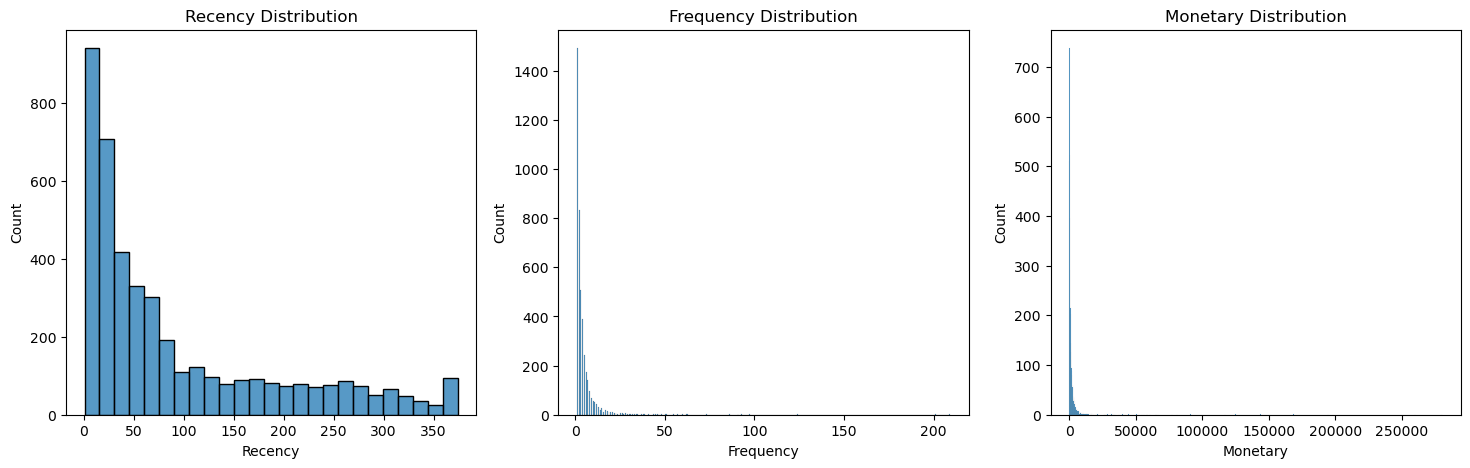

In [10]:
# Set reference date (e.g., one day after the last invoice date)
latest_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM calculation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                 # Frequency
    'TotalPrice': 'sum'                                     # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


import seaborn as sns

# Histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm['Recency'], ax=axes[0])
sns.histplot(rfm['Frequency'], ax=axes[1])
sns.histplot(rfm['Monetary'], ax=axes[2])
axes[0].set_title('Recency Distribution')
axes[1].set_title('Frequency Distribution')
axes[2].set_title('Monetary Distribution')


# FEATURE SCALING

In [11]:
from sklearn.preprocessing import StandardScaler

# Step 1: Select the RFM features
rfm_feature = rfm[['Recency', 'Frequency', 'Monetary']]

# Step 2: Apply StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_feature)

# Step 3: Convert to DataFrame
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

# Display first 5 rows
print(rfm_scaled_df.head())


    Recency  Frequency  Monetary
0  2.334574  -0.425097  8.363010
1 -0.905340   0.354417  0.251699
2 -0.175360  -0.035340 -0.027988
3 -0.735345  -0.425097 -0.032406
4  2.174578  -0.425097 -0.190812


In [12]:
# Optional: Split for testing or validation
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(rfm_scaled_df, test_size=0.2, random_state=42)

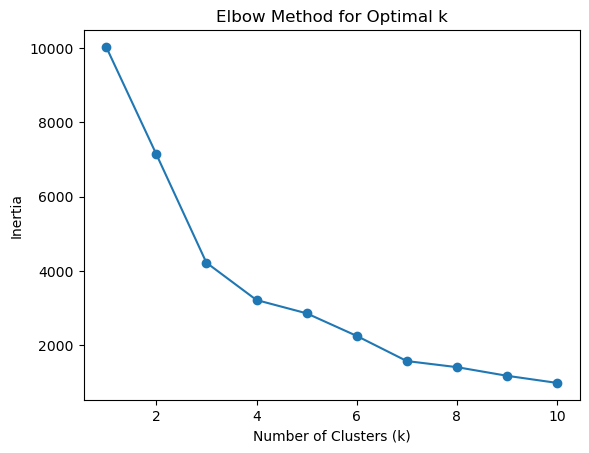

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [14]:
# 1. Fit KMeans on scaled RFM data (4338 customers)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled_df)

# 2. Now merge these customer-level clusters into the transaction-level df
df = df.merge(rfm[['CustomerID', 'Cluster']], on='CustomerID', how='left')

# 3. Check result
print(df[['CustomerID', 'Cluster']].head())


   CustomerID  Cluster
0     17850.0        3
1     17850.0        3
2     17850.0        3
3     17850.0        3
4     17850.0        3


In [15]:
rfm_profiles = rfm.groupby('Cluster').mean().round(2)
print(rfm_profiles)


         CustomerID  Recency  Frequency   Monetary
Cluster                                           
0          15289.13    43.70       3.68    1353.63
1          15347.79   248.08       1.55     478.85
2          15435.00     7.38      82.54  127187.96
3          15212.86    15.50      22.33   12690.50


In [16]:
def label_cluster(row):
    if row['Cluster'] == 0:
        return "High-Value"
    elif row['Cluster'] == 1:
        return "Regular"
    elif row['Cluster'] == 2:
        return "Occasional"
    elif row['Cluster'] == 3:
        return "At-Risk"

rfm['Segment'] = rfm.apply(label_cluster, axis=1)


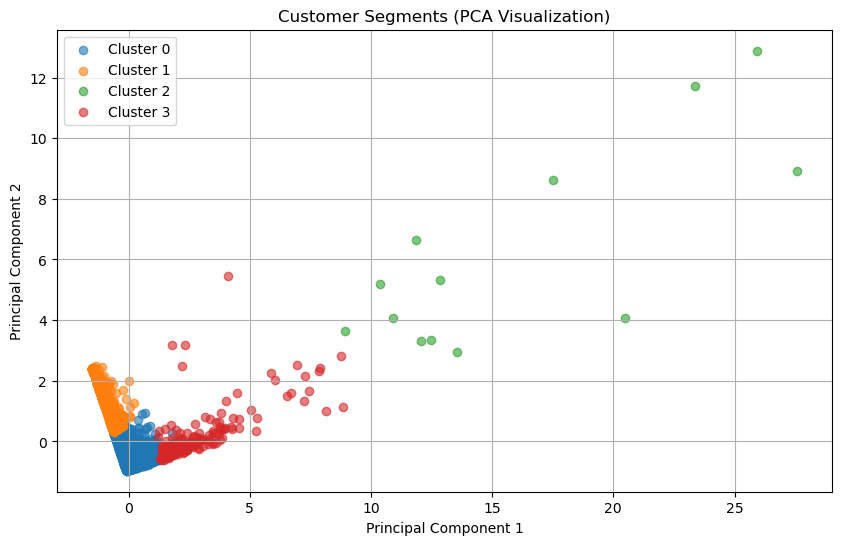

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled_df)

# Step 2: Create a DataFrame with PCA results and clusters
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = rfm['Cluster']

# Step 3: Visualize clusters in 2D
plt.figure(figsize=(10, 6))
for cluster in sorted(pca_df['Cluster'].unique()):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.6)

plt.title('Customer Segments (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import pickle
# 🔁 Step 7: Product Recommendation System (Collaborative Filtering)
# ------------------------------------
user_item_matrix = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc='sum').fillna(0)
item_item_matrix = user_item_matrix.T
similarity_matrix = cosine_similarity(item_item_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=item_item_matrix.index, columns=item_item_matrix.index)

# Recommendation function
def recommend_products(stock_code, top_n=5):
    if stock_code not in similarity_df:
        return []
    similar_items = similarity_df[stock_code].sort_values(ascending=False).drop(stock_code)
    return similar_items.head(top_n).index.tolist()



In [26]:
# ✅ Save model files
import os
save_dir = r"C:\Users\Rakshitha\customer\models"
os.makedirs(save_dir, exist_ok=True)

with open(os.path.join(save_dir, 'kmeans_model.pkl'), 'wb') as f:
    pickle.dump(kmeans, f)

with open(os.path.join(save_dir, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

with open(os.path.join(save_dir, 'similarity_matrix.pkl'), 'wb') as f:
    pickle.dump(similarity_df, f)

print("✅ All model files saved in:", save_dir)

✅ All model files saved in: C:\Users\Rakshitha\customer\models
